# Reference Upper-Air Network for trend analysis

Production date: 11-11-2024

Produced by: V. Ciardini (ENEA), P. Grigioni (ENEA), G. Pace (ENEA), C. Scarchilli (ENEA) and P.Trisolino (ENEA)

## 🌍 Use case: A study on changing temperature over the Arctic region

## ❓ Quality assessment question
* **Is the tropospheric Arctic warming amplification consistently detectable (across sites) in the GRUAN measurements?**

```{admonition} Due to data download temporarly closed on CDS, we present in the follow a first draft of the JN - to be replaced with the final quality assesment analysis later
:class: note

The evidences, both direct and indirect, indicate a substantial warming of the Arctic over recent decades. Furthermore, models project that the region will warm more rapidly than the global average over the remainder of this century, with likely considerable impacts on the environment, ecosystems and human activities. Various processes contributing to Arctic amplification result in global warming being effectively larger in the Arctic region. Amplifying feedback mechanisms are based on atmosphere-cryosphere-ocean interactions, with the diminishing of the Arctic Sea ice cover playing a leading role.
Understanding the climate change, and the underlying causes, requires an understanding not just of changes at the surface of the Earth, but throughout the atmospheric column.

```

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
**The expected main outcome of the obtained results – to be replaced with the final quality assessment statement later**
* Characterization of changes in key climate variables, in particular temperature and humidity
* Moistening and warming trends in the whole Arctic (considering the behaviour over different Arctic sites)
* Quantification of trends, including uncertainty analysis.
```

## 📋 Methodology
To answer the proposed question, we intend to focus on observations at Ny-Ålesund, Sodankyla and Barrow, the three Arctic GRUAN stations, following part of the methodology of [[1]](https://link.springer.com/article/10.1007/s00704-016-1864-0), where a homogenised 22-year Ny-Ålesund radiosonde dataset was analysed to infer changes in vertical temperature and humidity profiles over two decades (1993 to 2014). It should be noted that Ny-Ålesund has been the first radiosonde station certified by GRUAN. The authors found that in NYA, the integrated water vapour (IWV) calculated from radiosonde humidity measurements over two decades, indicates an increase in atmospheric moisture over the years (much faster in winter) and a corresponding warming of the atmospheric column in January and February.

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](section-1)**
* At this stage, only 1-month of data for NYA has been used; download from CDS is temporarily closed.

**[](section-2)**
* Radiosounding data are interpolated on a regular altitude grid with 50 m vertical resolution; the mean profile and standard deviation are calculated

**[](section-3)** 

**[](section-4)** 
* to be completed when downloading is re-established

**[](section-5)** 
* to be completed when downloading is re-established

**[](section-6)** 
* to be completed when downloading is re-established

## 📈 Analysis and results

(section-1)=
### 1. Set up and data retrieval for the three stations (NYA, SOD and BAR).

The User will be working with data in CSV format. To handle this data effectively, libraries for working with multidimensional arrays, particularly Xarray, will be utilised. The User will also require libraries for visualising data, in this case Matplotlib, and for statistical analysis, Scipy.

**Code:**

* Import packages and set parameters;
* open data and add attributes;
* define functions to cache;
* transform data.

In [2]:
#import libraries
import earthkit.data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

plt.style.use("seaborn-v0_8-notebook")

In [3]:
# set parameters
# TODO: Temporary workaround as the CDS download form is disabled
filename = "GRUAN_20160201_20160229_subset_cdm-lev_nya.csv"

```{admonition} Warning
:class: note
At this stage we report a draft of the analysis computed starting from 1-month data of NYA station  – to be replaced with the final quality assessment analysis later once the data download in CDS will be opened again)
```

In [4]:
# open data and add parameters

ds = earthkit.data.from_source(
    "file", filename, pandas_read_csv_kwargs={"header": 17}
).to_xarray()
ds["time"] = ("index", pd.to_datetime(ds["report_timestamp"]).values)
ds = ds.where(ds["station_name"] == "NYA", drop=True)
variable_attrs = {
    "air_pressure": {"long_name": "Pressure", "units": "Pa"},
    "air_temperature": {"long_name": "Temperature", "units": "K"},
    "altitude": {"long_name": "Altitude", "units": "m"},
    "relative_humidity": {"long_name": "Relative Humidity", "units": "%"},
}
for variable, attrs in variable_attrs.items():
    ds[variable].attrs.update(attrs)

#Define transform functions

def compute_specific_humidity(ds):
    pressure_hpa = ds["air_pressure"] * 0.01
    temperature_celsius = ds["air_temperature"] - 273.15
    sat_vap_p = 6.112 * np.exp(
        (17.67 * temperature_celsius) / (temperature_celsius + 243.5)
    )
    da = 622 * ds["relative_humidity"] * sat_vap_p / (100 * pressure_hpa)
    da.attrs = {"long_name": "Specific Humidity", "units": "g/kg"}
    return da

def compute_saturation_vapor_pressure(ds):
    temperature = ds["air_temperature"] - 273.15
    return 6.112 * np.exp((17.67 * temperature) / (temperature + 243.5))

def compute_integrated_water_vapour(ds):
    e_s = compute_saturation_vapor_pressure(ds)
    e = e_s * (ds["relative_humidity"]) / 100
    rho_v = (e * 18.015) / (10 * 8.3145 * ds["air_temperature"])
    iwv_value = rho_v * ds["altitude"].diff("altitude")
    da = iwv_value.sum("altitude")
    da.attrs = {"long_name": "Integrated Water Vapour", "units": "kg/m²"}
    return da

In [5]:
# transform data
# Add specific humidity
ds["specific_humidity"] = compute_specific_humidity(ds)

# Compute profiles
subset = ["air_temperature", "relative_humidity", "specific_humidity", "time"]
profiles = []
for time, profile in ds.groupby("time"):
    profile = profile.swap_dims(index="altitude")[subset]
    profile = profile.sortby("altitude").dropna("altitude", how="any", subset=subset)
    if (profile["altitude"].diff("altitude") > 2_000).any():
        continue

    profile = profile.interp(altitude=range(50, 30_001, 50))
    profiles.append(profile.expand_dims(time=[time]))
ds_profiles = xr.concat(profiles, "time")

# Compute integrated water vapour
da_iwv = compute_integrated_water_vapour(ds_profiles)

(section-2)=
### 2. Mean vertical profiles of temperature, relative humidity and specific humidity


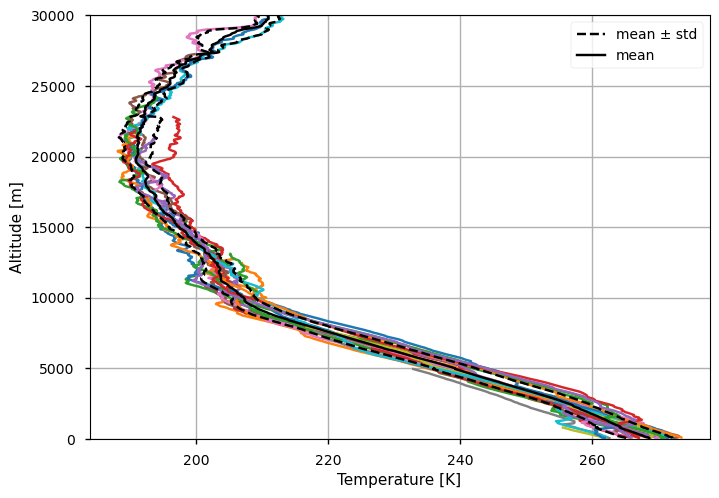

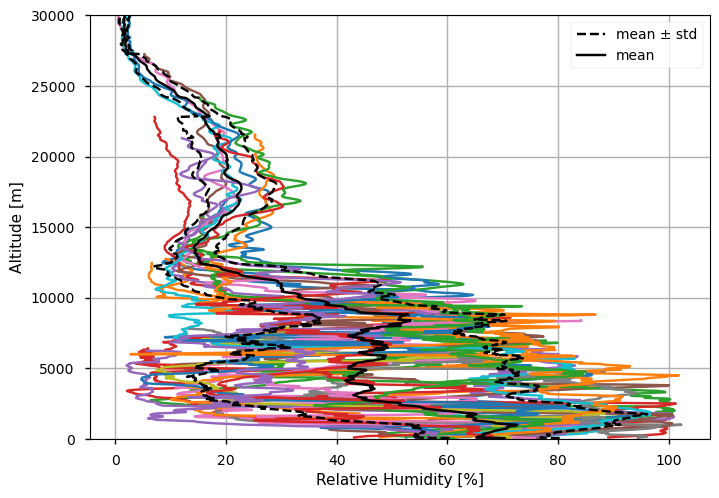

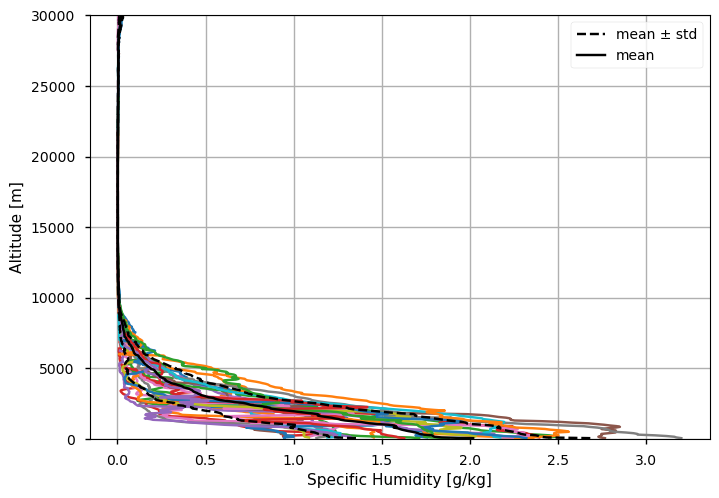

In [9]:
plot_kwargs = {"y": "altitude", "ylim": [0, 30000]}
for var, da in ds_profiles.data_vars.items():
    da.plot(hue="time", add_legend=False, **plot_kwargs)
    mean = da.mean("time", keep_attrs=True)
    std = da.std("time", keep_attrs=True)
    for sign in (-1, +1):
        (mean + std * sign).plot(
            color="k",
            linestyle="--",
            label="mean ± std" if sign > 0 else None,
            **plot_kwargs,
        )
    mean.plot(color="k", linestyle="-", label="mean", **plot_kwargs)
    plt.legend()
    plt.grid()
    plt.show()

**Figure 1**. 1-month of vertical profiles (in color) for temperature (the upper panel), relative humidity (middle) and specific humidity (lower panel) for NYA.The mean profiles with standard deviation are also reported (in black) 

(section-3)=
### 3. Calucation of the integrated water vapour

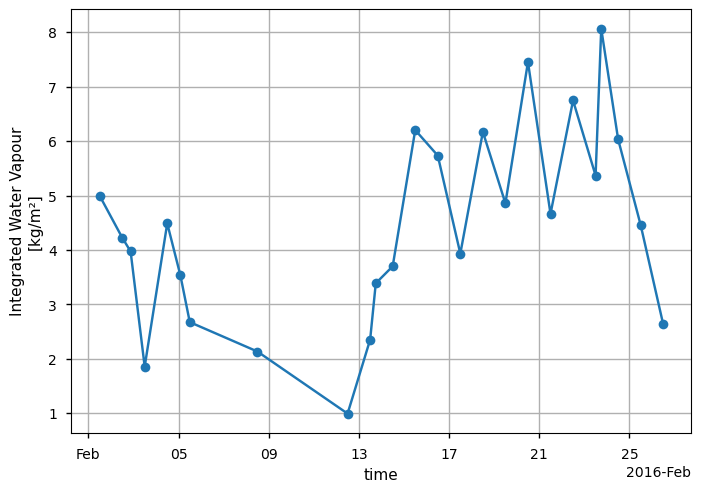

In [10]:
da_iwv.plot(marker="o")
plt.grid()

**Figure 2**. 1-month of integrated water vapour (blue) for NYA.

(section-4)=
### 4. Calculation of monthly mean IVW and temperature with associated uncertainties

(section-5)=
### 5. Trend estimation of IWV and T

(section-6)=
### 6. Discussion of the results for the three arctic sites.

## ℹ️ If you want to know more

### Key resources

[CDS entries](https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=overview), `In situ temperature, relative humidity and wind profiles from 2006 to March 2020 from the GRUAN reference network`

external pages:

[GRUAN website](https://www.gruan.org/), `GCOS Reference Upper-Air Network`

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)
* [Xarray](https://pypi.org/project/xarray/) for working with multidimensional arrays in Python
* [Matplotlib](https://pypi.org/project/matplotlib/) for visualization in Python 
* [Scipy](https://pypi.org/project/scipy/) for statistics in Python

### References

[[1]](https://link.springer.com/article/10.1007/s00704-016-1864-0) Maturilli, M., Kayser, M. Arctic warming, moisture increase and circulation changes observed in the Ny-Ålesund homogenized radiosonde record. Theor Appl Climatol 130, 1–17 (2017). https://doi.org/10.1007/s00704-016-1864-0